<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# TF-IDF Content-Based Recommendation on the COVID-19 Open Research Dataset
This demonstrates a simple implementation of Term Frequency Inverse Document Frequency (TF-IDF) content-based recommendation on the [COVID-19 Open Research Dataset](https://azure.microsoft.com/en-us/services/open-datasets/catalog/covid-19-open-research/), hosted through Azure Open Datasets.

In this notebook, we will create a recommender which will return the top k recommended articles similar to any article of interest (query item) in the COVID-19 Open Reserach Dataset.

In [1]:
# Set the environment path to find Recommenders
import sys
sys.path.append("../../")

# Import functions
from reco_utils.dataset.covid_utils import *
from reco_utils.recommender.tfidf.tfidf_utils import *

# Print version
print("System version: {}".format(sys.version))

System version: 3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]


Set the default parameters for accessing the dataset.

In [2]:
# Parameters for the COVID-19 dataset in Azure Open Datasets
azure_storage_account_name='azureopendatastorage'
azure_storage_sas_token='sv=2019-02-02&ss=bfqt&srt=sco&sp=rlcup&se=2025-04-14T00:21:16Z&st=2020-04-13T16:21:16Z&spr=https&sig=JgwLYbdGruHxRYTpr5dxfJqobKbhGap8WUtKFadcivQ%3D'
container_name='covid19temp'
metadata_filename='metadata.csv'

### 1. Download the dataset
Let's begin by downloading the metadata file for the dataset. This file contains metadata about each of the scientific articles included in the full dataset.

In [3]:
# Get metadata (may take around 1-2 min)
blob_service = get_blob_service(azure_storage_account_name, azure_storage_sas_token, container_name)
metadata = download_metadata(blob_service, container_name, metadata_filename)

### 2. Extract articles in the public domain
The dataset contains articles using a variety of licenses. We will only be using articles that fall under the public domain ([cc0](https://creativecommons.org/publicdomain/zero/1.0/)).

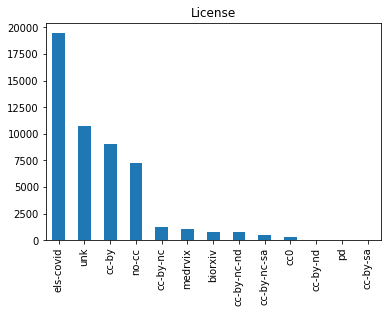

In [4]:
# View distribution of license types in the dataset
metadata['license'].value_counts().plot(kind='bar', title='License')

In [5]:
# Extract metadata on public domain articles only
metadata_public = extract_public_domain(metadata)

# Clean dataframe
metadata_public = clean_dataframe(metadata_public)

Let's look at the top few rows of this dataframe which contains metadata on public domain articles.

In [6]:
# Preview metadata for public domain articles
print('Number of articles in dataset: ' + str(len(metadata)))
print('Number of articles in dataset that fall under the public domain (cc0): ' + str(len(metadata_public)))
metadata_public.head()

Number of articles in dataset: 51078
Number of articles in dataset that fall under the public domain (cc0): 260


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
106,ej795nks,a3c3b7c38ad32e1042d78aae2027ca491e9f2197,PMC,Understanding the Spatial Clustering of Severe...,10.1289/ehp.7117,PMC1247620,15531441.0,cc0,We applied cartographic and geostatistical met...,2004-07-27,"Lai, P.C.; Wong, C.M.; Hedley, A.J.; Lo, S.V.;...",Environ Health Perspect,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
108,9mzs5dl4,c1c6a98c21304f3788b20870b34afd8a115fa38c,PMC,The Application of the Haddon Matrix to Public...,10.1289/ehp.7491,PMC1257548,15866764.0,cc0,State and local health departments continue to...,2005-02-02,"Barnett, Daniel J.; Balicer, Ran D.; Blodgett,...",Environ Health Perspect,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
152,u7lz3spe,c56ffdaf1cfbae5a6ed0abea495eaf7fa1cbc031,PMC,Cynomolgus Macaque as an Animal Model for Seve...,10.1371/journal.pmed.0030149,PMC1435788,16605302.0,cc0,BACKGROUND: The emergence of severe acute resp...,2006-04-18,"Lawler, James V; Endy, Timothy P; Hensley, Lis...",PLoS Med,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
160,na7z92i8,f38f3b112e4b702b60ba56be806d418bbb2b83c3,PMC,Immune Protection of Nonhuman Primates against...,10.1371/journal.pmed.0030177,PMC1459482,16683867.0,cc0,BACKGROUND: Ebola virus causes a hemorrhagic f...,2006-05-16,"Sullivan, Nancy J; Geisbert, Thomas W; Geisber...",PLoS Med,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
212,j35w1vsw,5dc0b8b662824323881c3a1ae3a1bae2a821484d,PMC,SARS: Systematic Review of Treatment Effects,10.1371/journal.pmed.0030343,PMC1564166,16968120.0,cc0,BACKGROUND: The SARS outbreak of 2002–2003 pre...,2006-09-12,"Stockman, Lauren J; Bellamy, Richard; Garner, ...",PLoS Med,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...


### 3. Retrieve full article text
Now that we have the metadata for the public domain articles as its own dataframe, let's retrieve the full text for each public domain scientific article.

In [7]:
# Extract text from all public domain articles (may take 2-3 min)
all_text = get_public_domain_text(metadata_public, blob_service, container_name)

../..\reco_utils\dataset\covid_utils.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'][row] = retrieve_text(df.iloc[row], blob_service, container_name)
C:\Users\Administrator\.conda\envs\rec_repo\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Notice that **all_text** is the same as **metadata_public** but now has an additional column called **full_text** which contains the full text for each respective article.

In [8]:
# Preview
all_text.head()

,index,cord_uid,doi,title,publish_time,authors,journal,url,abstract,full_text
0,0,ej795nks,10.1289/ehp.7117,Understanding the Spatial Clustering of Severe...,2004-07-27,"Lai, P.C.; Wong, C.M.; Hedley, A.J.; Lo, S.V.;...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,We applied cartographic and geostatistical met...,Since the emergence and rapid spread of the e...
1,1,9mzs5dl4,10.1289/ehp.7491,The Application of the Haddon Matrix to Public...,2005-02-02,"Barnett, Daniel J.; Balicer, Ran D.; Blodgett,...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,State and local health departments continue to...,"sudden fever and dry cough, along with chills..."
2,2,u7lz3spe,10.1371/journal.pmed.0030149,Cynomolgus Macaque as an Animal Model for Seve...,2006-04-18,"Lawler, James V; Endy, Timothy P; Hensley, Lis...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: The emergence of severe acute resp...,The emergence of severe acute respiratory syn...
3,3,na7z92i8,10.1371/journal.pmed.0030177,Immune Protection of Nonhuman Primates against...,2006-05-16,"Sullivan, Nancy J; Geisbert, Thomas W; Geisber...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: Ebola virus causes a hemorrhagic f...,Background Ebola virus causes a hemorrhagic f...
4,4,j35w1vsw,10.1371/journal.pmed.0030343,SARS: Systematic Review of Treatment Effects,2006-09-12,"Stockman, Lauren J; Bellamy, Richard; Garner, ...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND: The SARS outbreak of 2002–2003 pre...,The SARS outbreak of 2002-2003 presented clin...


### 4. Prepare text for use in the TF-IDF recommender
The raw text retrieved for each article requires basic cleaning prior to being used in the TF-IDF model.

Let's look at the full_text from the first article in our dataframe as an example.

In [9]:
# Preview the full scientific text from one example
print(all_text['full_text'][0])

 Since the emergence and rapid spread of the etiologic agent of severe acute respiratory syndrome (SARS)-SARS coronavirus (SARS-CoV)-in late 2002 and during the first 6 months of 2003, great progress has been made in understanding the biology, pathogenesis, and epidemiology of both the disease and the virus (SARS-CoV). Much remains to be done, however, including the development of effective therapeutic interventions and diagnostic tools with high sensitivity and specificity soon after the onset of clinical symptoms. The evaluation of key epidemiologic parameters and the impact of different public health interventions in the various settings that experienced minor or major epidemics is also needed (Affonso et al. 2004; Cui et al. 2003; Lau et al. 2004; Leung et al., in press) . In terms of outbreak control on the population level, many questions about "superspreading events" (SSEs) remain to be investigated. Such an SSE was responsible for > 300 cases (out of a total of 1,755) in the Am

As seen above, there are some special characters (such as • ▲ ■ ≥ °) and punctuation which should be removed prior to using the text as input. Casing (capitalization) is preserved for [BERT-based tokenization methods](https://huggingface.co/transformers/model_doc/bert.html), but is removed for simple or no tokenization.

Let's join together the **abstract** and **full_text** columns and clean them for future use in the TF-IDF model.

In [10]:
# Assign columns to clean and combine
cols_to_clean = ['abstract','full_text']
df_clean = clean_dataframe_for_rec(all_text, cols_to_clean, for_BERT=True)

../..\reco_utils\recommender\tfidf\tfidf_utils.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = clean_text(df[col][i], for_BERT)
../..\reco_utils\recommender\tfidf\tfidf_utils.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'][i] = df['title'][i].encode('ascii','ignore')
../..\reco_utils\recommender\tfidf\tfidf_utils.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'][i] = df['title'][i].decode(

In [11]:
# Preview the dataframe with the cleaned text
df_clean.head()

,index,cord_uid,doi,title,publish_time,authors,journal,url,abstract,full_text,cleaned_text
0,0,ej795nks,10.1289/ehp.7117,Understanding the Spatial Clustering of Severe...,2004-07-27,"Lai, P.C.; Wong, C.M.; Hedley, A.J.; Lo, S.V.;...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,We applied cartographic and geostatistical met...,Since the emergence and rapid spread of the e...,We applied cartographic and geostatistical met...
1,1,9mzs5dl4,10.1289/ehp.7491,The Application of the Haddon Matrix to Public...,2005-02-02,"Barnett, Daniel J.; Balicer, Ran D.; Blodgett,...",Environ Health Perspect,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,State and local health departments continue to...,sudden fever and dry cough along with chills ...,State and local health departments continue to...
2,2,u7lz3spe,10.1371/journal.pmed.0030149,Cynomolgus Macaque as an Animal Model for Seve...,2006-04-18,"Lawler, James V; Endy, Timothy P; Hensley, Lis...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND The emergence of severe acute respi...,The emergence of severe acute respiratory syn...,BACKGROUND The emergence of severe acute respi...
3,3,na7z92i8,10.1371/journal.pmed.0030177,Immune Protection of Nonhuman Primates against...,2006-05-16,"Sullivan, Nancy J; Geisbert, Thomas W; Geisber...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND Ebola virus causes a hemorrhagic fe...,Background Ebola virus causes a hemorrhagic f...,BACKGROUND Ebola virus causes a hemorrhagic fe...
4,4,j35w1vsw,10.1371/journal.pmed.0030343,SARS: Systematic Review of Treatment Effects,2006-09-12,"Stockman, Lauren J; Bellamy, Richard; Garner, ...",PLoS Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,BACKGROUND The SARS outbreak of 20022003 prese...,The SARS outbreak of 20022003 presented clini...,BACKGROUND The SARS outbreak of 20022003 prese...


In [12]:
# Preview the cleaned version of the previous example
df_clean['cleaned_text'][0]

'We applied cartographic and geostatistical methods in analyzing the patterns of disease spread during the 2003 severe acute respiratory syndrome SARS outbreak in Hong Kong using geographic information system GIS technology We analyzed an integrated database that contained clinical and personal details on all 1755 patients confirmed to have SARS from 15 February to 22 June 2003 Elementary mapping of disease occurrences in space and time simultaneously revealed the geographic extent of spread throughout the territory Statistical surfaces created by the kernel method confirmed that SARS cases were highly clustered and identified distinct disease hot spots Contextual analysis of mean and standard deviation of different density classes indicated that the period from day 1 18 February through day 16 6 March was the prodrome of the epidemic whereas days 86 15 May to 106 4 June marked the declining phase of the outbreak Originanddestination plots showed the directional bias and radius of spre

### 5. Rank articles by similarity using TF-IDF
For each public domain article, generate a sorted list of all the other public domain articles in the dataset. This list is sorted by each article's similarity to the article of interest, calculated using cosine similarity on the respective TF-IDF vectors.

Select one of the following tokenization methods to use in the model:

| tokenization_method | Description                                                                                                                      |
|:--------------------|:---------------------------------------------------------------------------------------------------------------------------------|
| 'none'              | No tokenization is applied. Each word is considered a token.                                                                     |
| 'nltk'              | Simple stemming is applied using NLTK.                                                                                           |
| 'bert'              | HuggingFace BERT word tokenization ('bert-base-cased') is applied.                                                               |
| 'scibert'           | SciBERT word tokenization ('allenai/scibert_scivocab_cased') is applied.<br>This is recommended for scientific journal articles. |

In [13]:
# TF-IDF with tokenization_method of 'nltk', 'bert', 'scibert', or 'none'
results = recommend_with_tfidf(df_clean,
                               text_col='cleaned_text',
                               id_col='cord_uid',
                               title_col='title',
                               tokenization_method='scibert')

# Organize results as an easy-to-read table (may take about 30 sec)
num_of_recs_to_keep = 5
rec_table = organize_results_as_tabular(df_clean,
                                        results,
                                        id_col='cord_uid',
                                        k=num_of_recs_to_keep)

In our recommendation table, each row representats a single recommendation.

**cord_uid** and **title** correspond to the article that is being used to make recommendations from. **rec_rank** contains the recommdation's rank (e.g., rank of 1 means top recommendation). **rec_score** is the cosine similarity score between the query article and the recommended article. **rec_cord_uid** and **rec_title** correspond to the recommended article.

In [14]:
# Preview the recommendations
rec_table

,cord_uid,title,rec_rank,rec_score,rec_cord_uid,rec_title
0,ej795nks,Understanding the Spatial Clustering of Severe...,1,0.141480,u7lz3spe,Cynomolgus Macaque as an Animal Model for Seve...
1,ej795nks,Understanding the Spatial Clustering of Severe...,2,0.116403,j35w1vsw,SARS: Systematic Review of Treatment Effects
2,ej795nks,Understanding the Spatial Clustering of Severe...,3,0.100148,nt60lv2k,A Network Integration Approach to Predict Cons...
3,ej795nks,Understanding the Spatial Clustering of Severe...,4,0.076347,vp9d9vmp,Genome Wide Identification of SARS-CoV Suscept...
4,ej795nks,Understanding the Spatial Clustering of Severe...,5,0.074854,05d1mhkq,A Porcine Epidemic Diarrhea Virus Outbreak in ...
...,...,...,...,...,...,...
1230,bxr2utuo,"Fellowships, Grants, & Awards",1,0.081344,lv09i0kg,Developing international open science collabor...
1231,bxr2utuo,"Fellowships, Grants, & Awards",2,0.067072,q4r22jtg,"Prioritization of Zoonotic Diseases in Kenya, ..."
1232,bxr2utuo,"Fellowships, Grants, & Awards",3,0.060705,vocsxblm,Towards Equity in Health: Researchers Take Stock
1233,bxr2utuo,"Fellowships, Grants, & Awards",4,0.057416,7gs54990,Understanding and Managing Zoonotic Risk in th...


### 6. Display top recommendations for article of interest
Now that we have the recommendation table containing IDs for both query and recommended articles, we can easily return the full metadata for the top k recommendations for any given article.

In [15]:
display_top_recommendations(rec_table, metadata_public, query_id='ej795nks', id_col='cord_uid')

../..\reco_utils\recommender\tfidf\tfidf_utils.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['authors'][i] = rec_info['authors']
../..\reco_utils\recommender\tfidf\tfidf_utils.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['journal'][i] = rec_info['journal']
../..\reco_utils\recommender\tfidf\tfidf_utils.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['publish_time'][i] = rec_info['publish_time']
../..\reco_u

,rank,similarity_score,title,authors,journal,publish_time,url
0,1,0.14148,Cynomolgus Macaque as an Animal Model for Severe Acute Respiratory Syndrome,"Lawler, James V; Endy, Timothy P; Hensley, Lisa E; Garrison, Aura; Fritz, Elizabeth A; Lesar, May; Baric, Ralph S; Kulesh, David A; Norwood, David A; Wasieloski, Leonard P; Ulrich, Melanie P; Slezak, Tom R; Vitalis, Elizabeth; Huggins, John W; Jahrling, Peter B; Paragas, Jason",PLoS Med,2006-04-18,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1435788/
1,2,0.116403,SARS: Systematic Review of Treatment Effects,"Stockman, Lauren J; Bellamy, Richard; Garner, Paul",PLoS Med,2006-09-12,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1564166/
2,3,0.100148,A Network Integration Approach to Predict Conserved Regulators Related to Pathogenicity of Influenza and SARS-CoV Respiratory Viruses,"Mitchell, Hugh D.; Eisfeld, Amie J.; Sims, Amy C.; McDermott, Jason E.; Matzke, Melissa M.; Webb-Robertson, Bobbi-Jo M.; Tilton, Susan C.; Tchitchek, Nicolas; Josset, Laurence; Li, Chengjun; Ellis, Amy L.; Chang, Jean H.; Heegel, Robert A.; Luna, Maria L.; Schepmoes, Athena A.; Shukla, Anil K.; Metz, Thomas O.; Neumann, Gabriele; Benecke, Arndt G.; Smith, Richard D.; Baric, Ralph S.; Kawaoka, Yoshihiro; Katze, Michael G.; Waters, Katrina M.",PLoS One,2013-07-25,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3723910/
3,4,0.076347,Genome Wide Identification of SARS-CoV Susceptibility Loci Using the Collaborative Cross,"Gralinski, Lisa E.; Ferris, Martin T.; Aylor, David L.; Whitmore, Alan C.; Green, Richard; Frieman, Matthew B.; Deming, Damon; Menachery, Vineet D.; Miller, Darla R.; Buus, Ryan J.; Bell, Timothy A.; Churchill, Gary A.; Threadgill, David W.; Katze, Michael G.; McMillan, Leonard; Valdar, William; Heise, Mark T.; Pardo-Manuel de Villena, Fernando; Baric, Ralph S.",PLoS Genet,2015-10-09,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4599853/
4,5,0.0748543,A Porcine Epidemic Diarrhea Virus Outbreak in One Geographic Region of the United States: Descriptive Epidemiology and Investigation of the Possibility of Airborne Virus Spread,"Beam, Andrea; Goede, Dane; Fox, Andrew; McCool, Mary Jane; Wall, Goldlin; Haley, Charles; Morrison, Robert",PLoS One,2015-12-28,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4692406/


In this notebook, we have demonstrated how to create a TF-IDF recommender to recommend the top k (in this case 5) articles similar in content to an article of interest (in this example, article with cord_uid='ej795nks').